In [3]:
# IMPORTING MODULES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, average_precision_score, roc_curve, auc

In [1]:
# GOOGLE COLAB SETUP

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 1. Importing Data

train = pd.read_csv('/content/drive/MyDrive/SJ-DECEN_code/data/train_cleaned_no_punkt.csv')
test_labelled = pd.read_csv('/content/drive/MyDrive/SJ-DECEN_code/data/test_labelled_cleaned_no_punkt.csv')
test_unlabelled = pd.read_csv('/content/drive/MyDrive/SJ-DECEN_code/data/test_unlabelled_cleaned_no_punkt.csv')

In [5]:
# 2. Create 'mal' label as binary
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['mal'] = (train[label_cols].sum(axis=1) >= 1).astype(int)
test_labelled['mal'] = (test_labelled[label_cols].sum(axis=1) >= 1).astype(int)

In [6]:
# 3. Drop multi-labels and fill missing text
train.drop(columns=label_cols, inplace=True)
test_labelled.drop(columns=label_cols, inplace=True)
train['comment_text'].fillna("empty", inplace=True)
test_labelled['comment_text'].fillna("empty", inplace=True)
test_unlabelled['comment_text'].fillna("empty", inplace=True)

In [ ]:
# 4. Stratified split for balance
rs = 42
X_train1, X_test1, y_train1, y_test1 = train_test_split(train['comment_text'], train['mal'], test_size=0.29, stratify=train['mal'], random_state=rs)
X_train2, X_test2, y_train2, y_test2 = train_test_split(test_labelled['comment_text'], test_labelled['mal'], test_size=0.29, stratify=test_labelled['mal'], random_state=rs)

# Combine data
X_train = np.concatenate([X_train1.values, X_train2.values])
y_train = np.concatenate([y_train1.values, y_train2.values])
X_test = np.concatenate([X_test1.values, X_test2.values])
y_test = np.concatenate([y_test1.values, y_test2.values])


In [ ]:
# 5. Tokenization and padding
vocab_size = 20000
max_len = 150
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

In [ ]:
# 6. Build BiLSTM model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# 7. Train the model
history = model.fit(X_train_pad, y_train, validation_split=0.2, epochs=5, batch_size=64)


Epoch 1/5
1984/1984 ━━━━━━━━━━━━━━━━━━━━ 843s 422ms/step - accuracy: 0.9322 - loss: 0.2136 - val_accuracy: 0.9379 - val_loss: 0.1421
Epoch 2/5
1984/1984 ━━━━━━━━━━━━━━━━━━━━ 823s 403ms/step - accuracy: 0.9628 - loss: 0.1005 - val_accuracy: 0.9400 - val_loss: 0.1522
Epoch 3/5
1984/1984 ━━━━━━━━━━━━━━━━━━━━ 850s 427ms/step - accuracy: 0.9695 - loss: 0.0789 - val_accuracy: 0.9299 - val_loss: 0.1869
Epoch 4/5
1984/1984 ━━━━━━━━━━━━━━━━━━━━ 844s 418ms/step - accuracy: 0.9760 - loss: 0.0607 - val_accuracy: 0.9273 - val_loss: 0.2262
Epoch 5/5
1984/1984 ━━━━━━━━━━━━━━━━━━━━ 856s 415ms/step - accuracy: 0.9809 - loss: 0.0477 - val_accuracy: 0.9211 - val_loss: 0.2624


In [ ]:
# 8. Evaluate the model
predictions = model.predict(X_test_pad).flatten()
predictions_bin = (predictions > 0.5).astype("int32")

accuracy = accuracy_score(y_test, predictions_bin)
class_report = classification_report(y_test, predictions_bin)
avg_precision = average_precision_score(y_test, predictions)

print(f'Accuracy: {accuracy:.4f}')
print("Classification Report:\n", class_report)
print(f'Average Precision Score: {avg_precision:.4f}')

2026/2026 ━━━━━━━━━━━━━━━━━━━━ 98s 48ms/step
Accuracy: 0.9491
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     58314
           1       0.75      0.75      0.75      6516

    accuracy                           0.95     64830
   macro avg       0.86      0.86      0.86     64830
weighted avg       0.95      0.95      0.95     64830

Average Precision Score: 0.8103


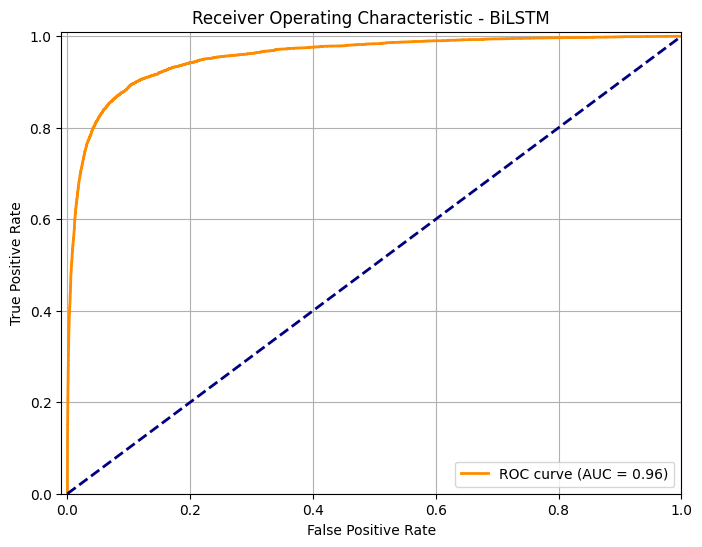

In [ ]:
# 9. Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - BiLSTM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()